# Calculating the Climatological and Anomaly Values for Selected CBP Stations

Creating a seasonal climatology of the mixed layer from the buoy stations.

[Station names](https://d18lev1ok5leia.cloudfront.net/chesapeakebay/documents/map_of_mainstem_and_tributary_monitoring_stations.pdf)

In [1]:
import os

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

In [17]:
SAVE_FIGS = True
REPO_ROOT = '/Users/rwegener/repos/chesapeake_mhw'

## Preprocessing

In [3]:
# Read the csv into a pandas dataframe
cols = ['EventId', 'Station', 'SampleDate', 'SampleTime', 'Unit',
        'Depth', 'Layer','MeasureValue', 'Latitude', 'Longitude']
path = os.path.join(REPO_ROOT, 'data/raw', 
                    'WaterQuality_ChesapeakeBayProgram_20030101_20221231.csv')
wq = pd.read_csv(path, usecols=cols, parse_dates=[2])

In [4]:
len(wq.Station.unique())

988

### Narrowing down a list of stations with enough evenly distributed data points


Used to use the 35 most sampled stations:
```
stations = wq.groupby('Station').count().sort_values(by='EventId').iloc[-35:].index
```

In [5]:
# Only consider measurements between 1 and 3 meters depth
wq_stations = wq[(wq.Depth > 1) & (wq.Depth < 3)]

In [6]:
# Only inspect stations with at least 20*12 data points (maybe remove this step later?)
# st_counts = wq.groupby('Station').count().sort_values(by='EventId')
# st_counts = st_counts[st_counts.EventId > 240]
# wq_stations = wq[wq.Station.isin(st_counts.index)]

In [7]:
stations = wq_stations.groupby('Station').count().sort_values(by='EventId').index

Check for temporal uniformity

In [8]:
counts = wq_stations.groupby(['Station', wq_stations.SampleDate.dt.year, wq_stations.SampleDate.dt.month]).count()['MeasureValue']

In [9]:
counts = pd.DataFrame(counts)
counts = counts.rename({'MeasureValue': 'ObsCount'}, axis=1)
counts.index = counts.index.set_names(['Station', 'year', 'month'])

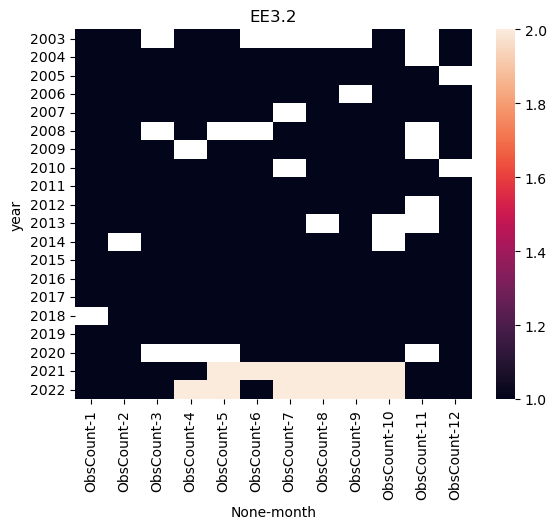

adding EE3.2 to stations_filtered


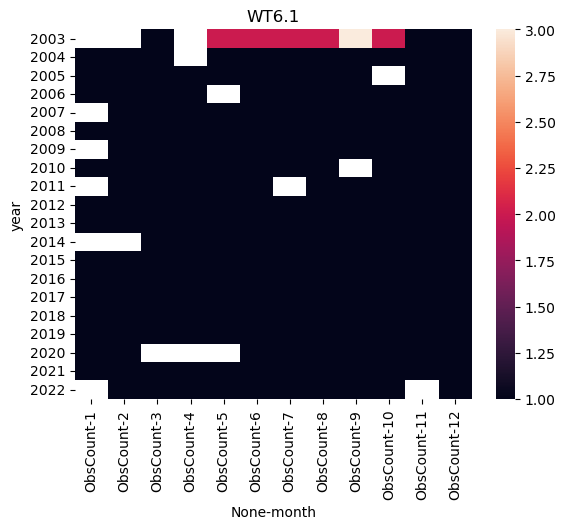

adding WT6.1 to stations_filtered


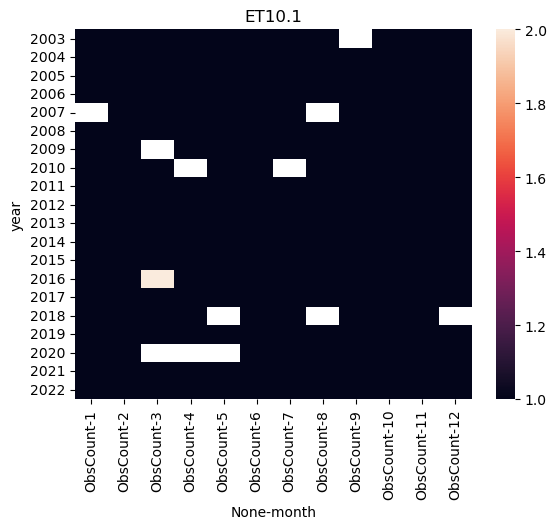

adding ET10.1 to stations_filtered


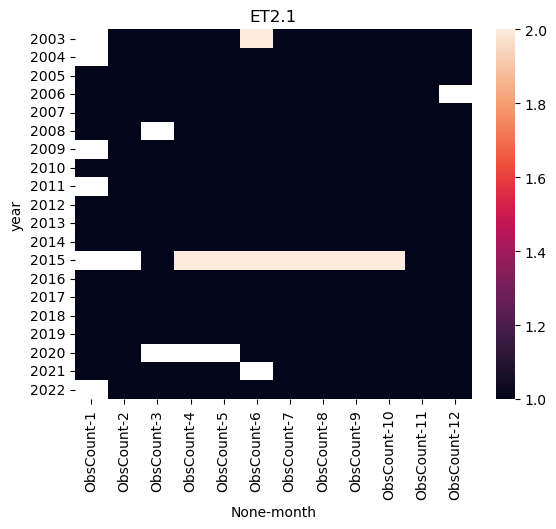

adding ET2.1 to stations_filtered


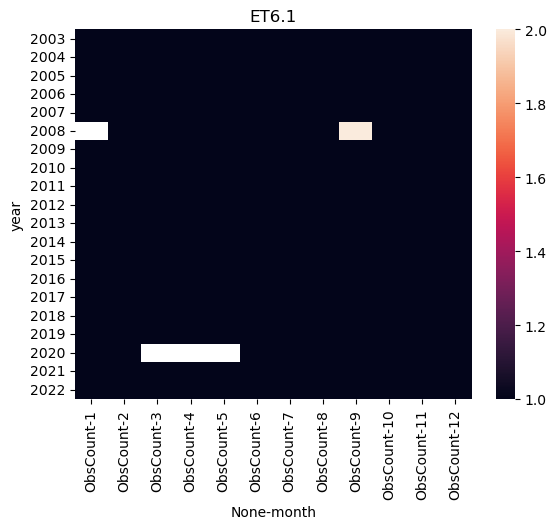

adding ET6.1 to stations_filtered


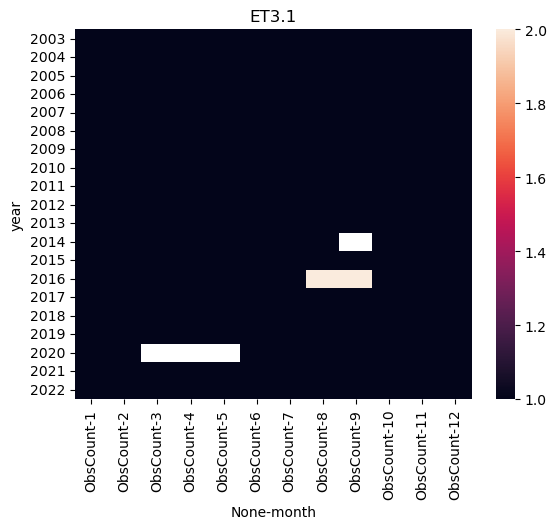

adding ET3.1 to stations_filtered


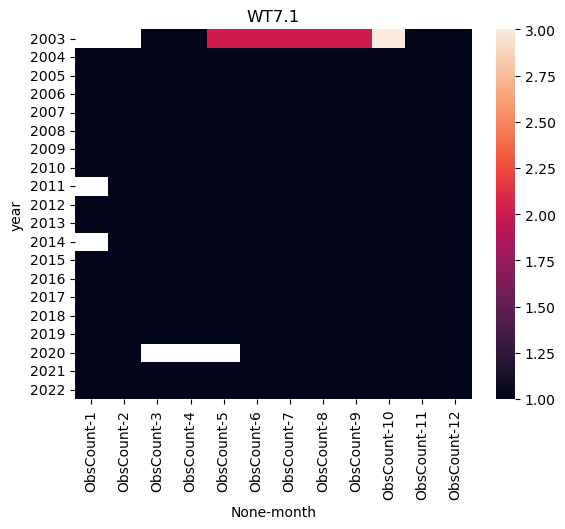

adding WT7.1 to stations_filtered


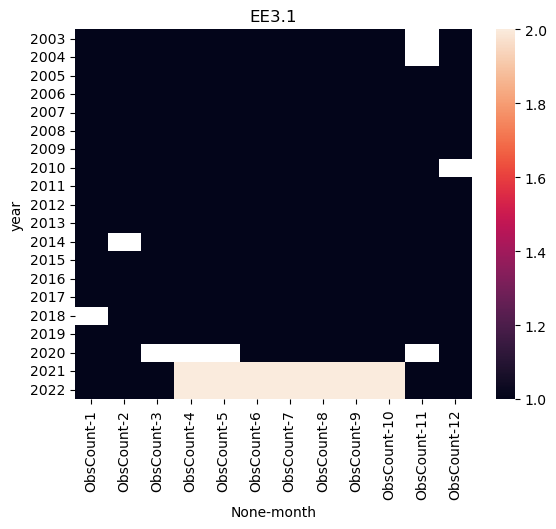

adding EE3.1 to stations_filtered


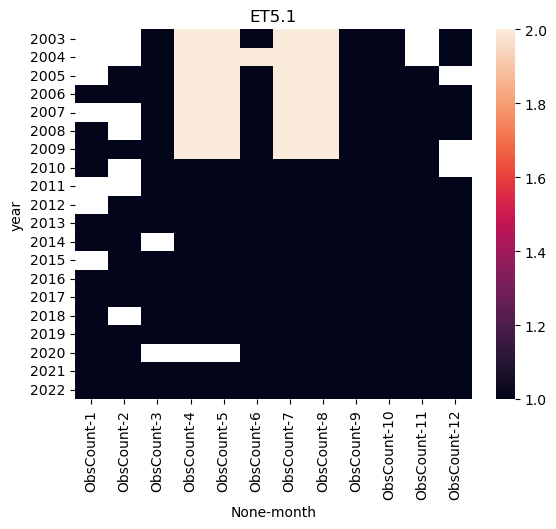

adding ET5.1 to stations_filtered


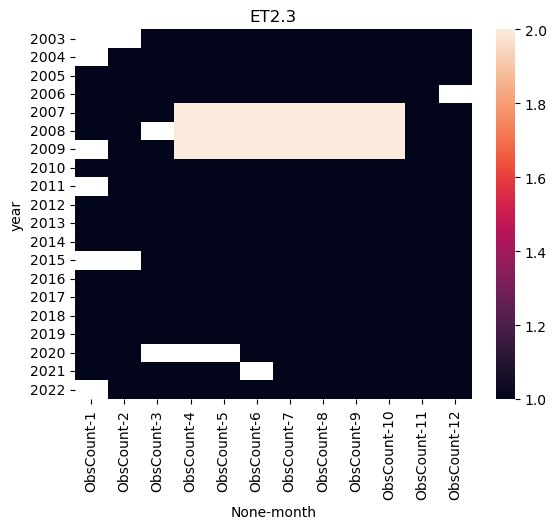

adding ET2.3 to stations_filtered


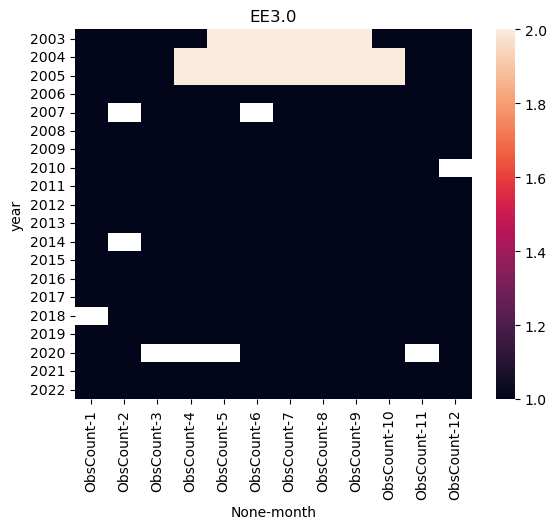

adding EE3.0 to stations_filtered


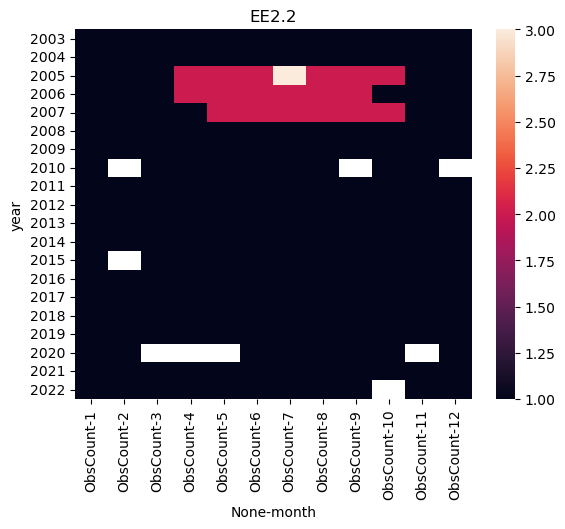

adding EE2.2 to stations_filtered


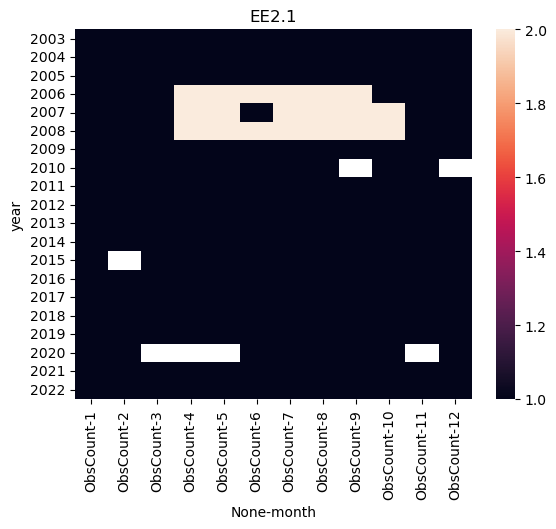

adding EE2.1 to stations_filtered


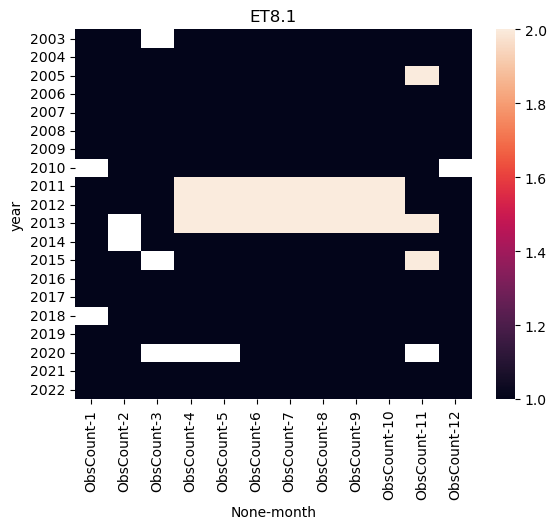

adding ET8.1 to stations_filtered


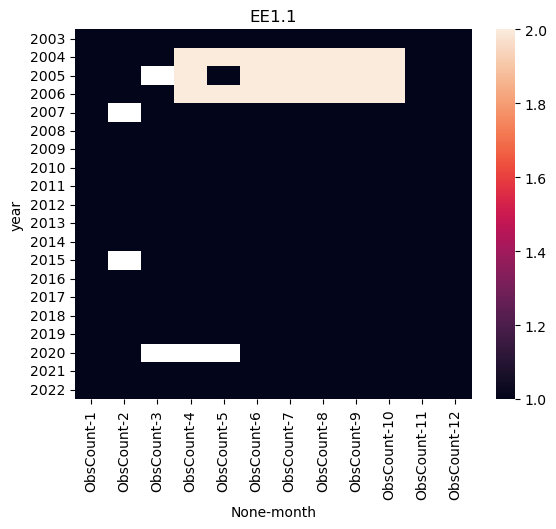

adding EE1.1 to stations_filtered


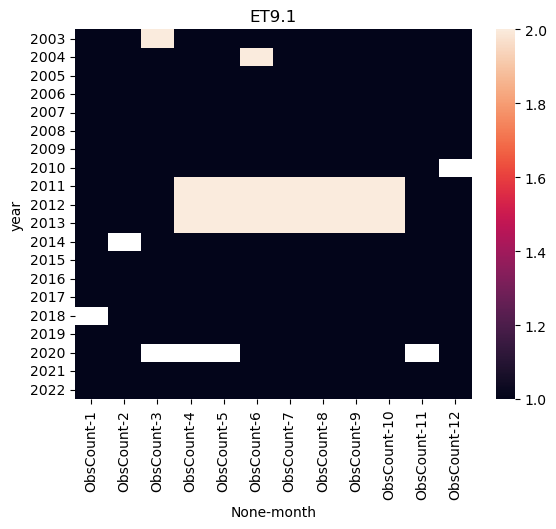

adding ET9.1 to stations_filtered


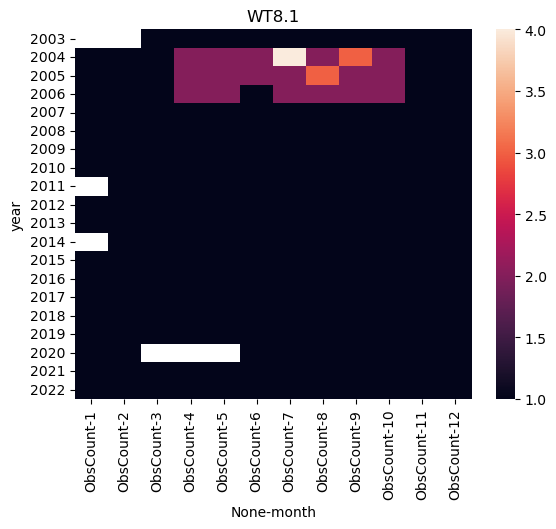

adding WT8.1 to stations_filtered


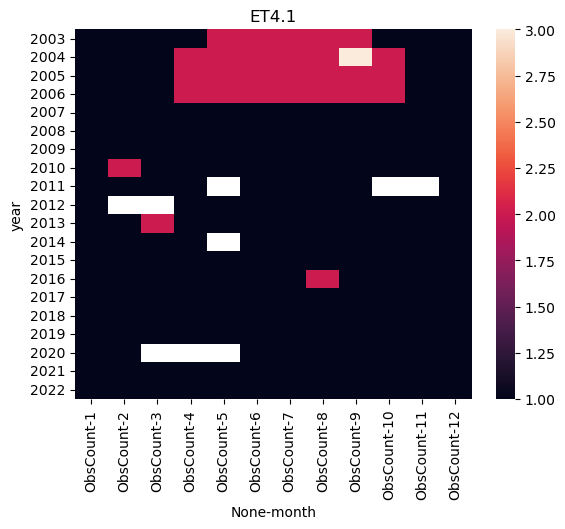

adding ET4.1 to stations_filtered


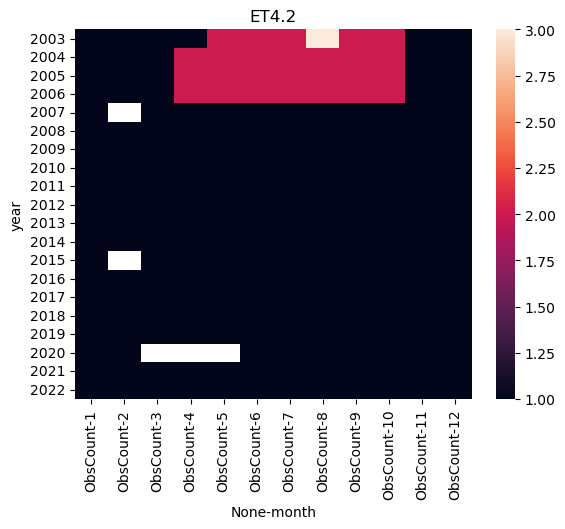

adding ET4.2 to stations_filtered


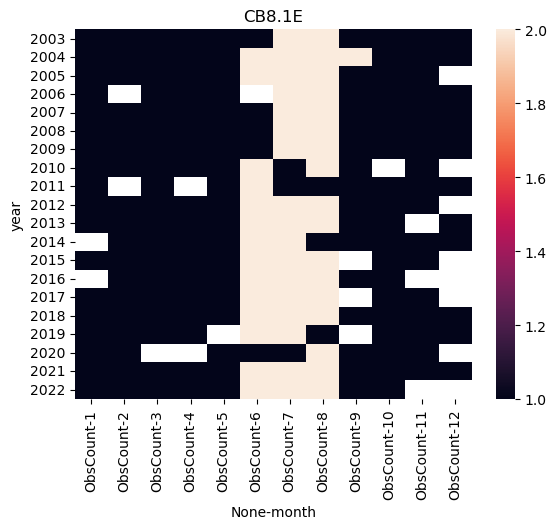

adding CB8.1E to stations_filtered


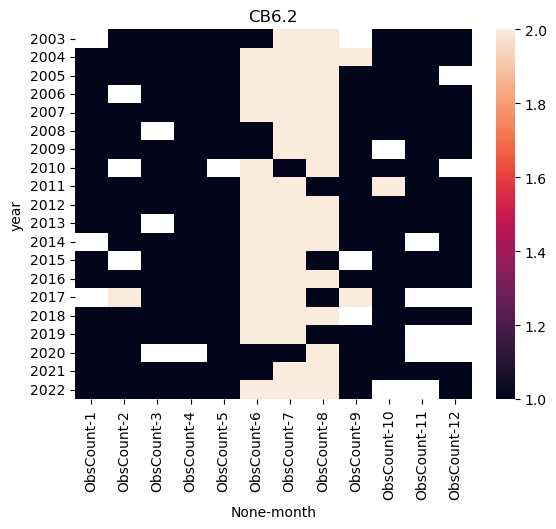

adding CB6.2 to stations_filtered


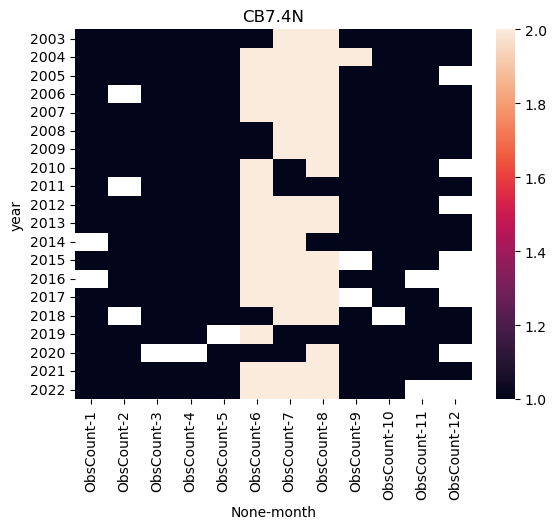

adding CB7.4N to stations_filtered


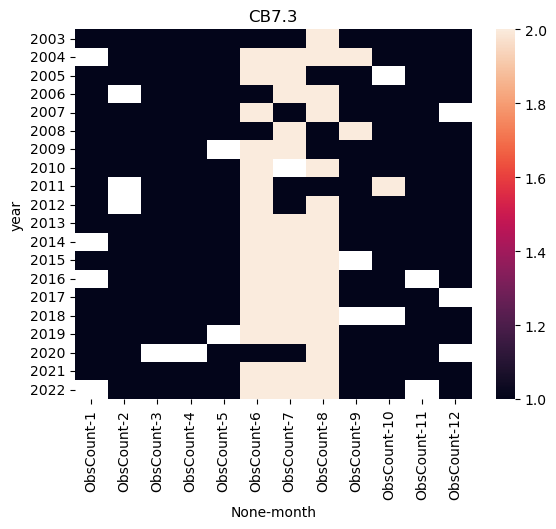

adding CB7.3 to stations_filtered


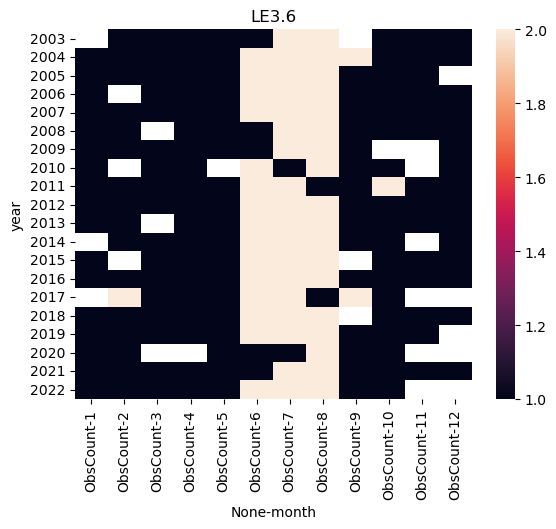

adding LE3.6 to stations_filtered


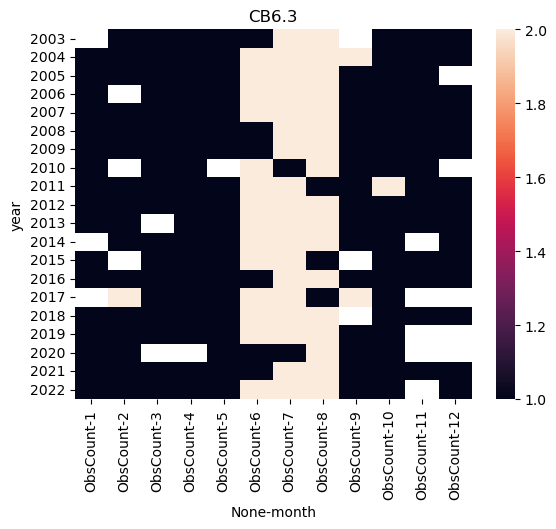

adding CB6.3 to stations_filtered


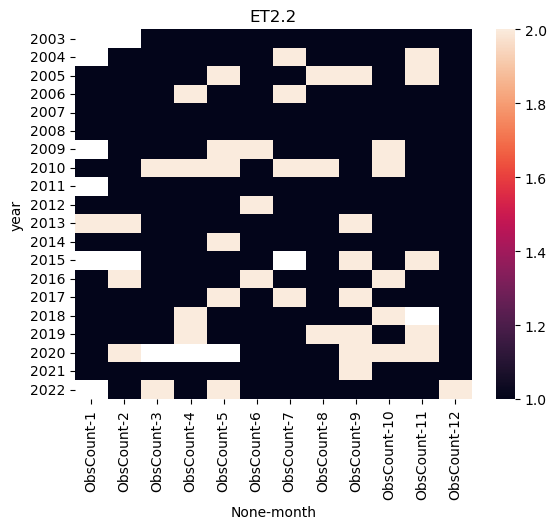

adding ET2.2 to stations_filtered


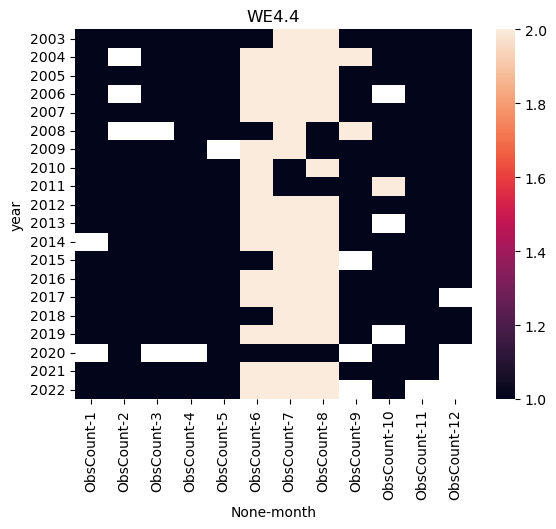

adding WE4.4 to stations_filtered


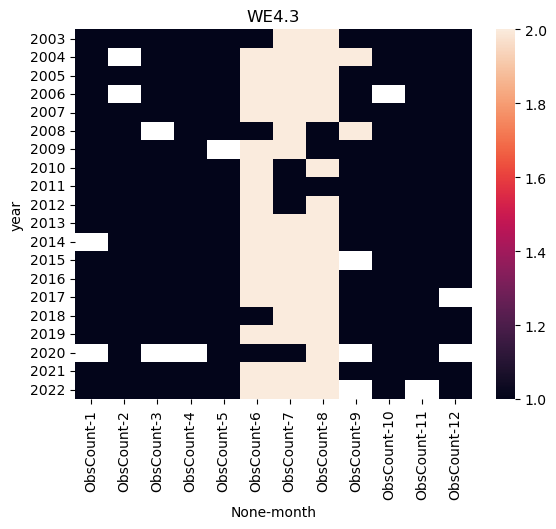

adding WE4.3 to stations_filtered


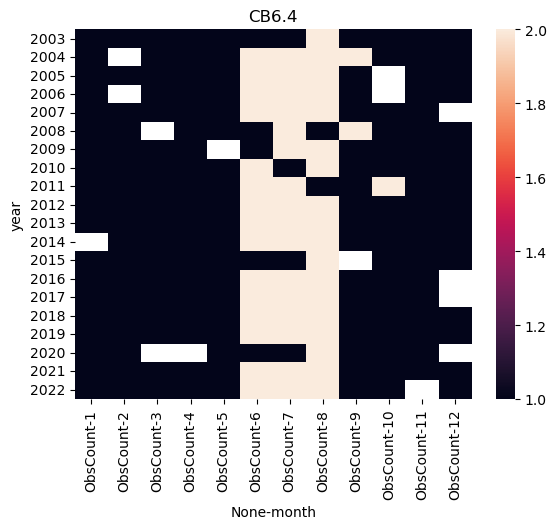

adding CB6.4 to stations_filtered


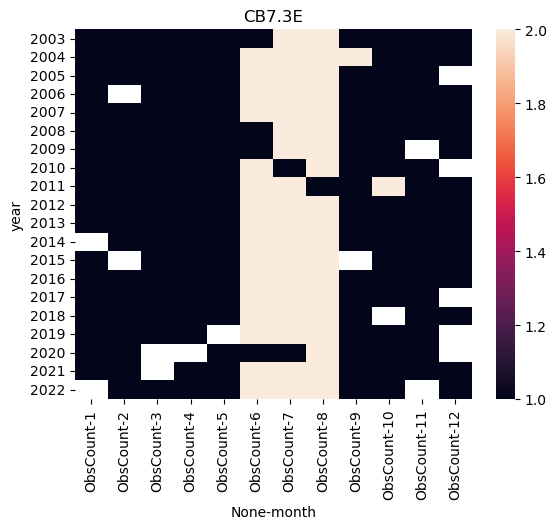

adding CB7.3E to stations_filtered


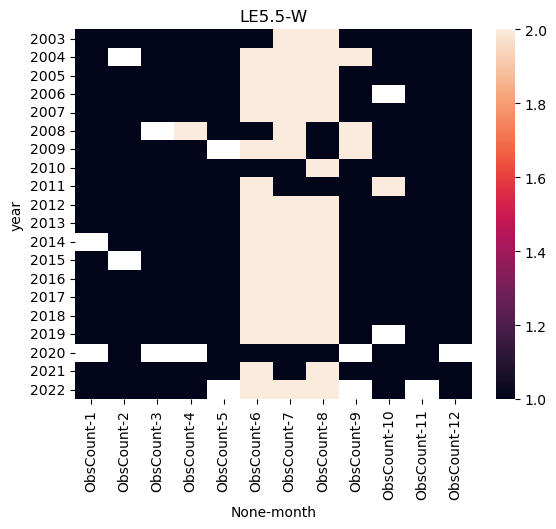

adding LE5.5-W to stations_filtered


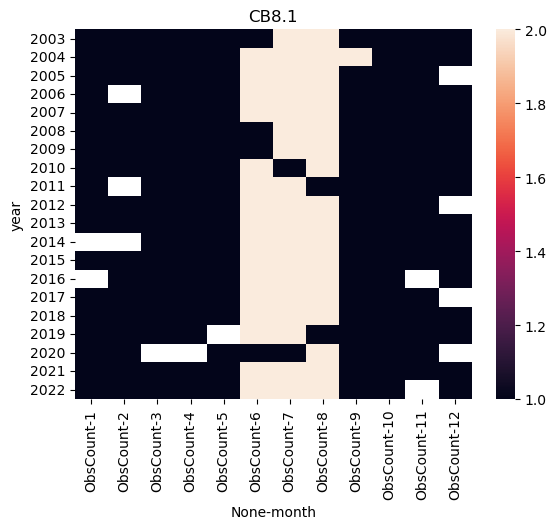

adding CB8.1 to stations_filtered


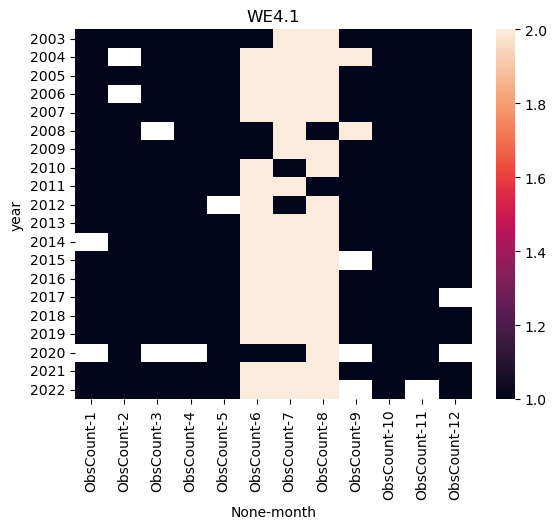

adding WE4.1 to stations_filtered


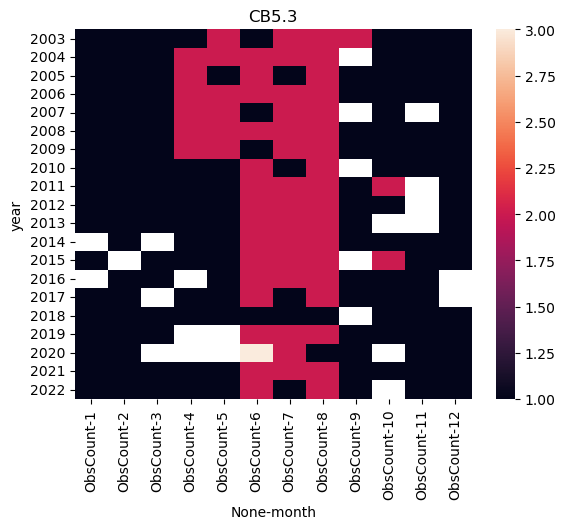

adding CB5.3 to stations_filtered


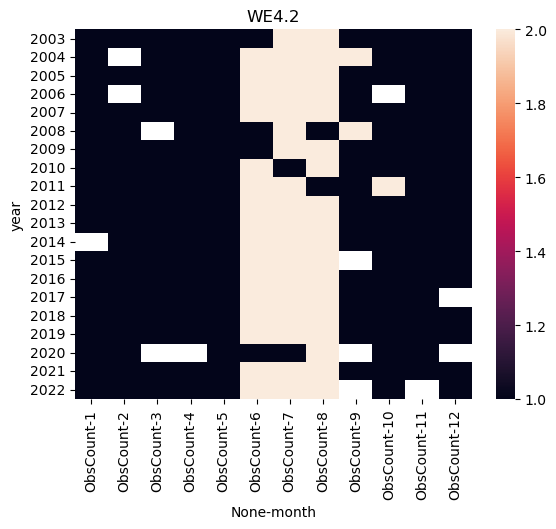

adding WE4.2 to stations_filtered


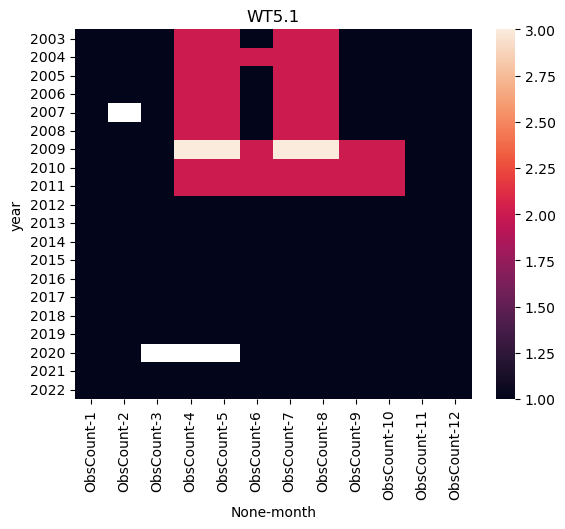

adding WT5.1 to stations_filtered


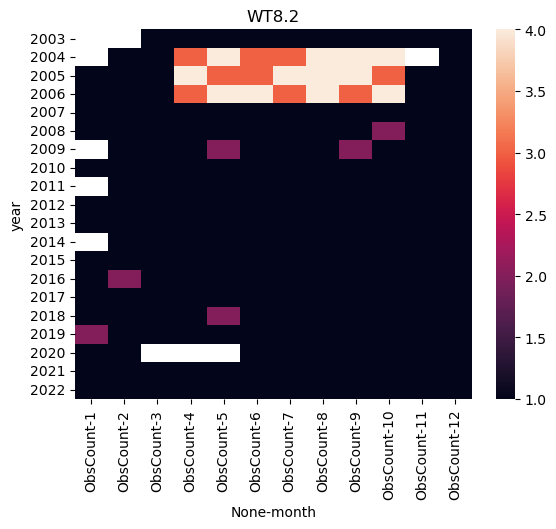

adding WT8.2 to stations_filtered


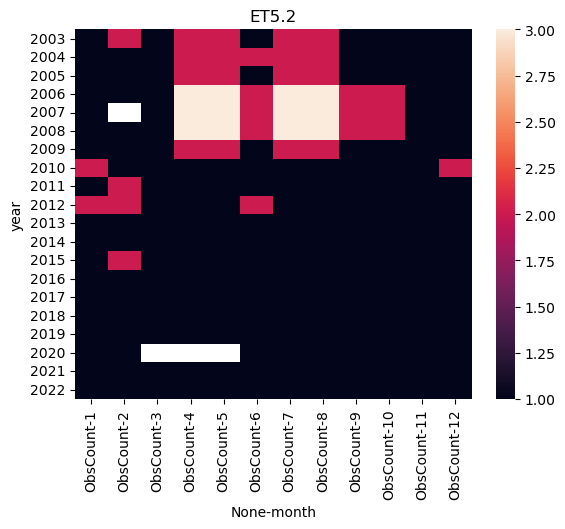

adding ET5.2 to stations_filtered


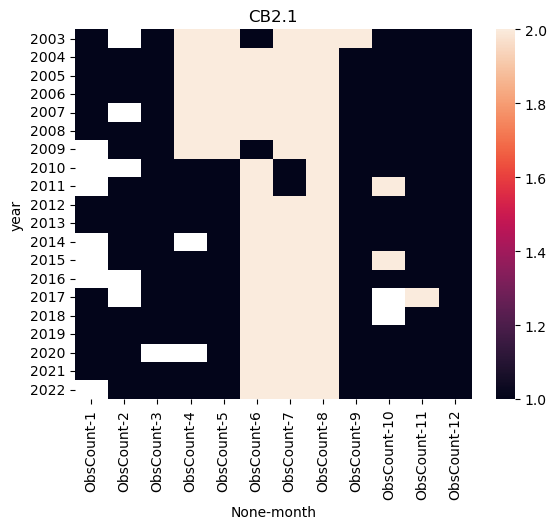

adding CB2.1 to stations_filtered


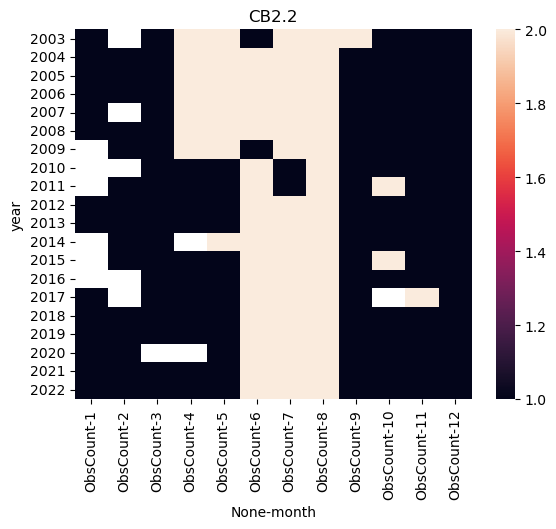

adding CB2.2 to stations_filtered


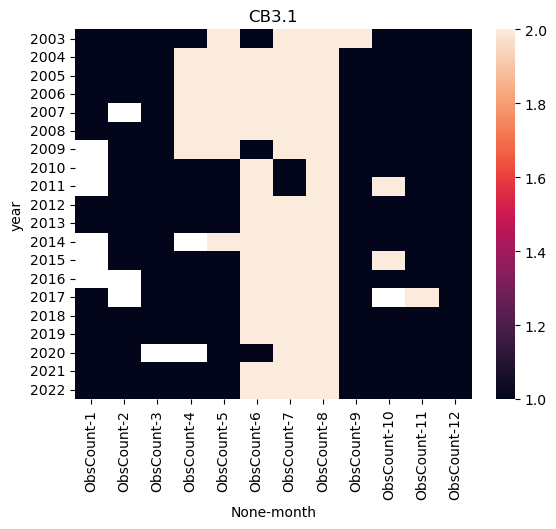

adding CB3.1 to stations_filtered


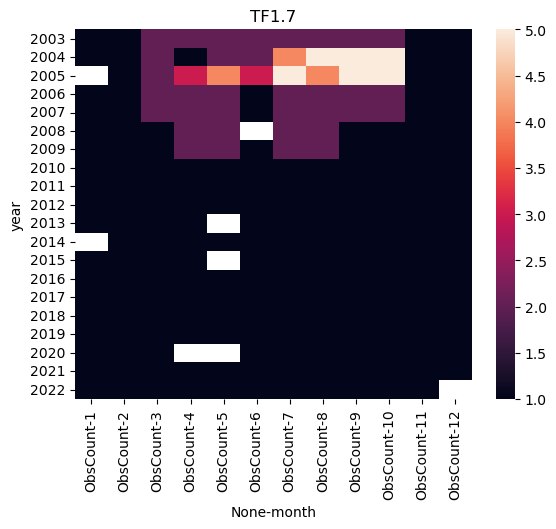

adding TF1.7 to stations_filtered


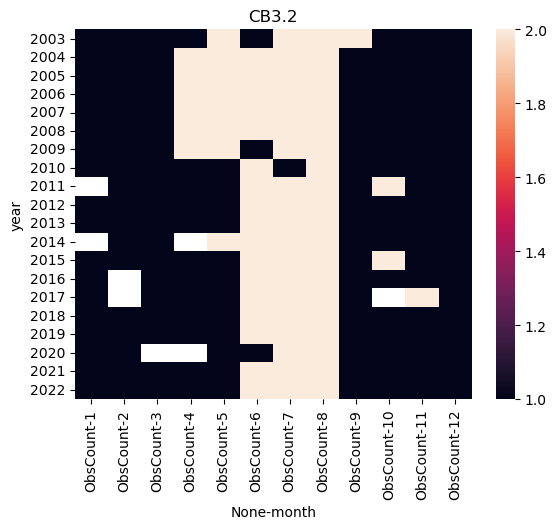

adding CB3.2 to stations_filtered


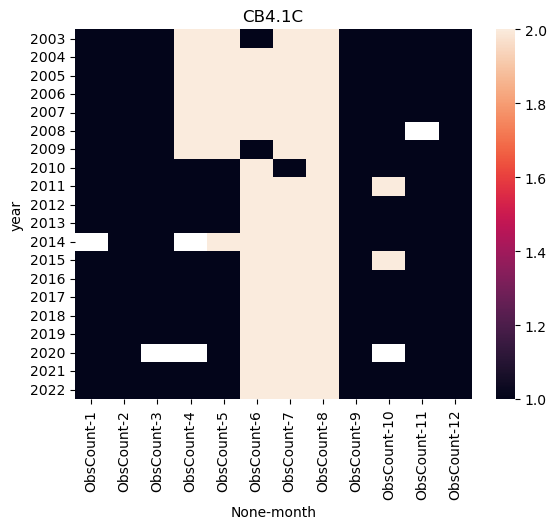

adding CB4.1C to stations_filtered


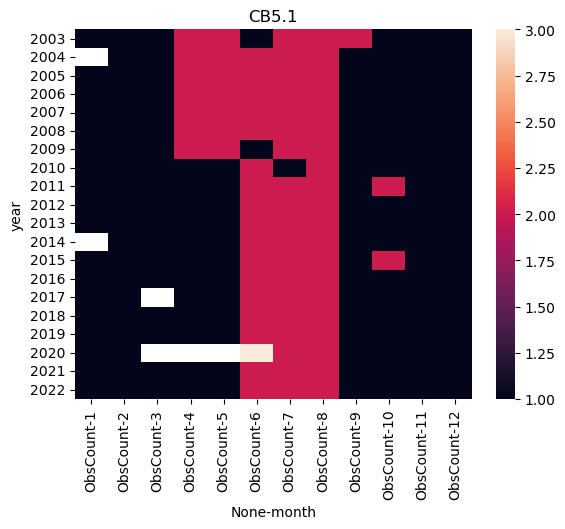

adding CB5.1 to stations_filtered


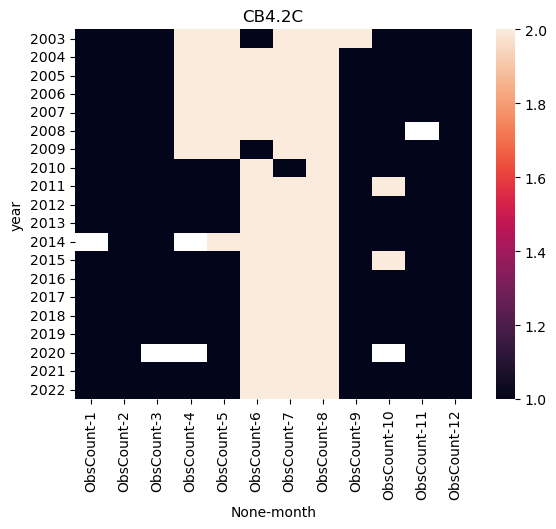

adding CB4.2C to stations_filtered


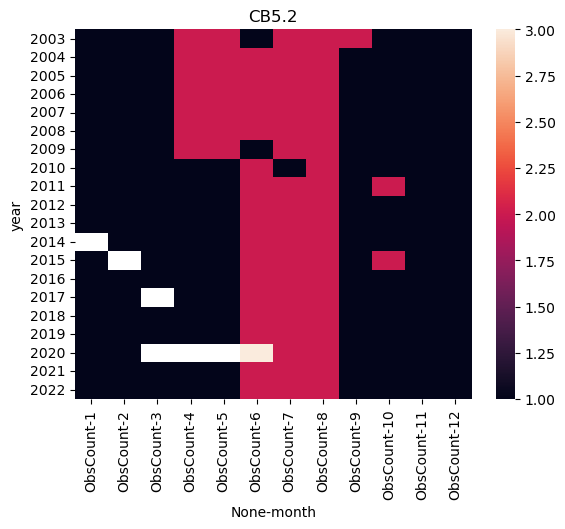

adding CB5.2 to stations_filtered


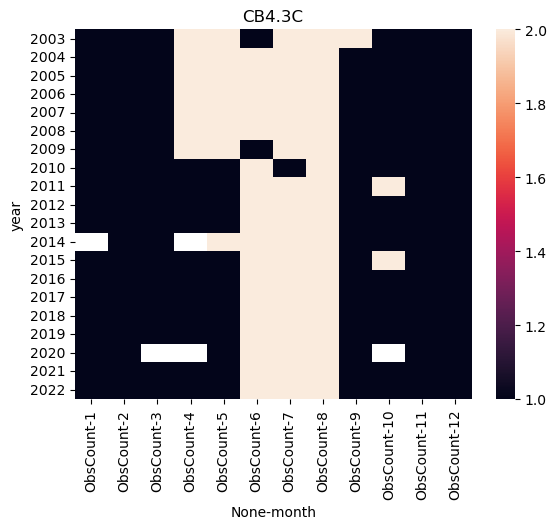

adding CB4.3C to stations_filtered


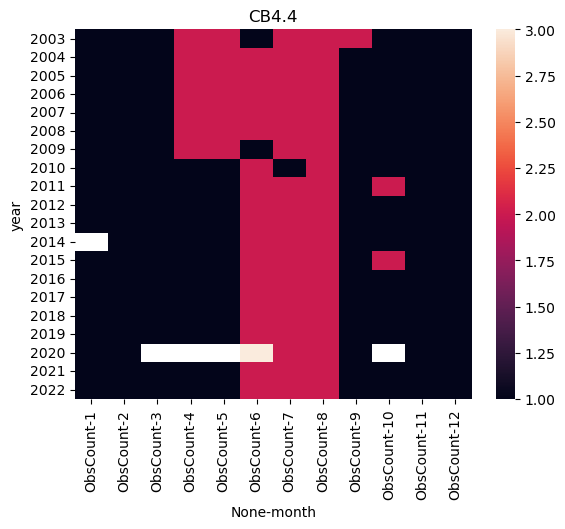

adding CB4.4 to stations_filtered


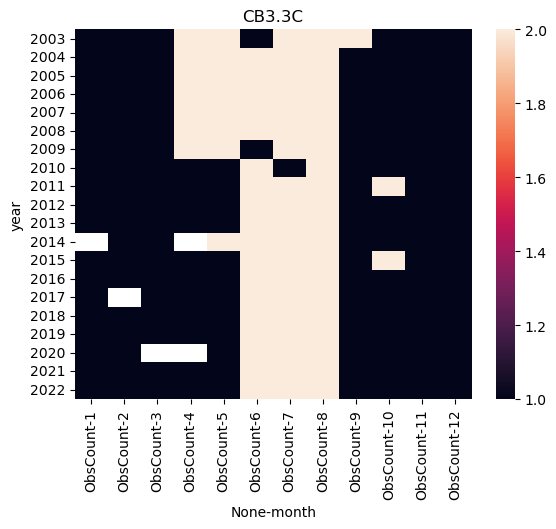

adding CB3.3C to stations_filtered


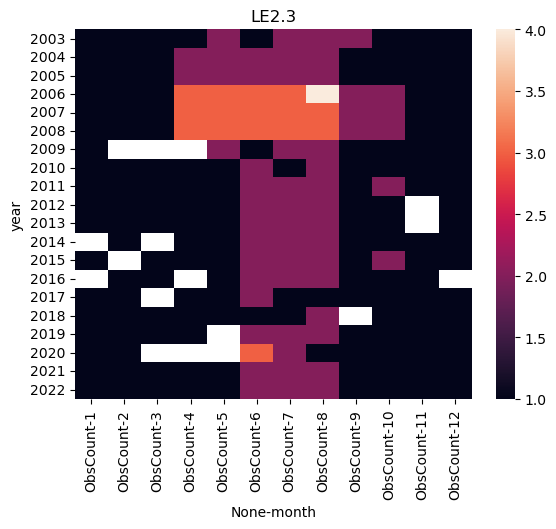

adding LE2.3 to stations_filtered


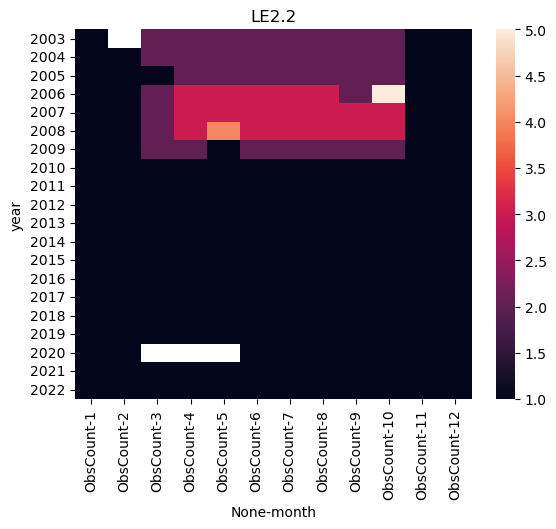

adding LE2.2 to stations_filtered


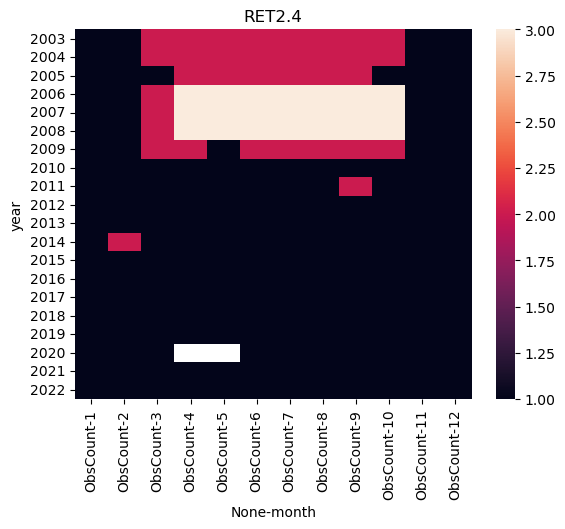

adding RET2.4 to stations_filtered


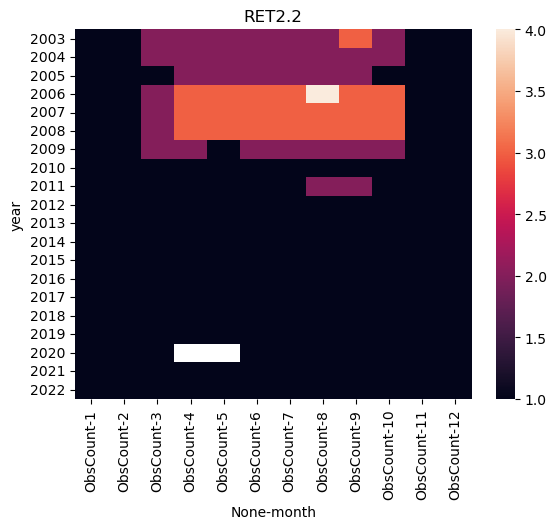

adding RET2.2 to stations_filtered


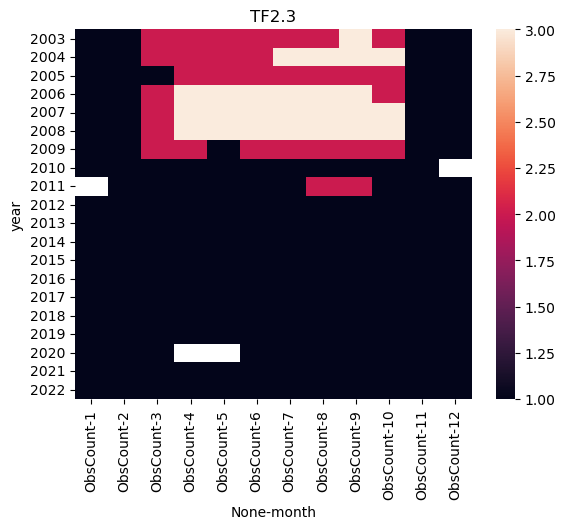

adding TF2.3 to stations_filtered


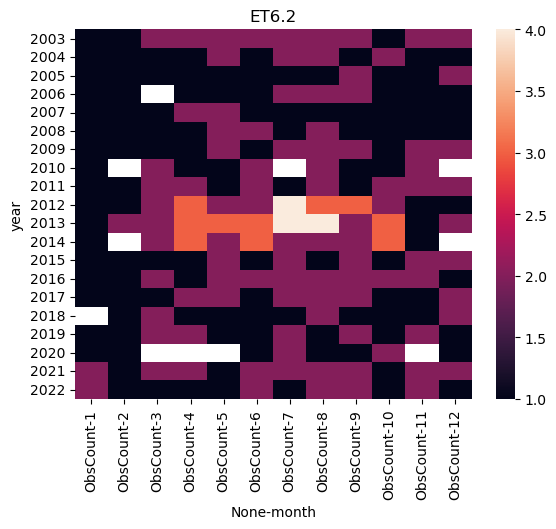

adding ET6.2 to stations_filtered


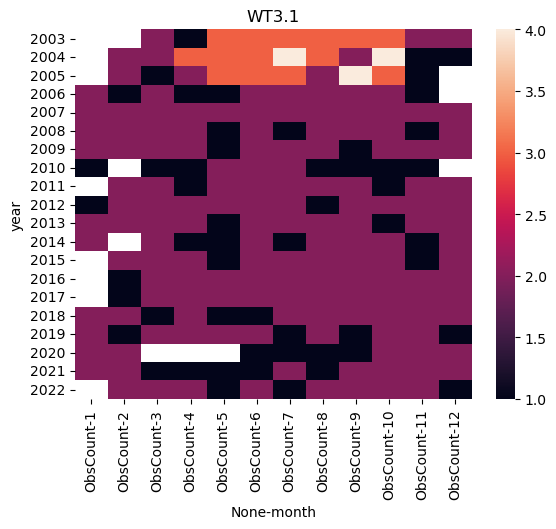

adding WT3.1 to stations_filtered


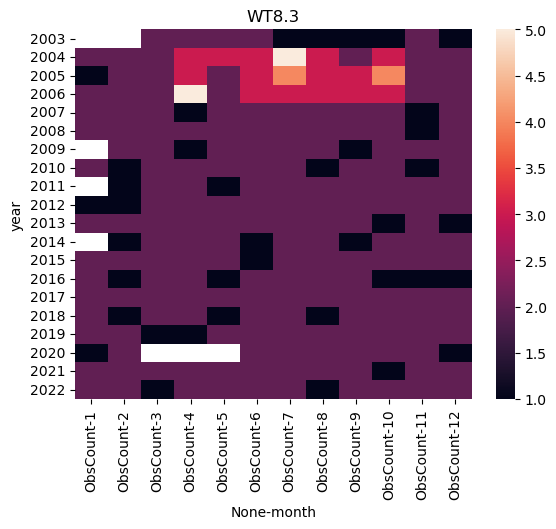

adding WT8.3 to stations_filtered


In [10]:
stations_filtered = []
completeness_df = pd.DataFrame(
    columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 
               'Nov', 'Dec']
)

for station in stations:
    # extract station
    df = counts.loc[station]
    # preprocessing
    df = df.reset_index()
    matrix = df.pivot(index='year', columns='month')
    
    # Add to filtered stations if it meets the condition
    if (matrix.sum() < 12).sum() > 0:
        # If any month does not have at least 12 years with an obs (60% coverage)
        # do not consider it
        continue
    # Check that there are at least 18 months with obs (90% coverage) in 10 of the months
    if ((~matrix.isna()).sum() >= 17).sum() >= 10:
        stations_filtered.append(station)
        # plot
        sns.heatmap(matrix)
        plt.title(station)
        plt.show()
        plt.close()
        print('adding', station, 'to stations_filtered')
        completeness_df.loc[station] = (~matrix.isna()).sum().values

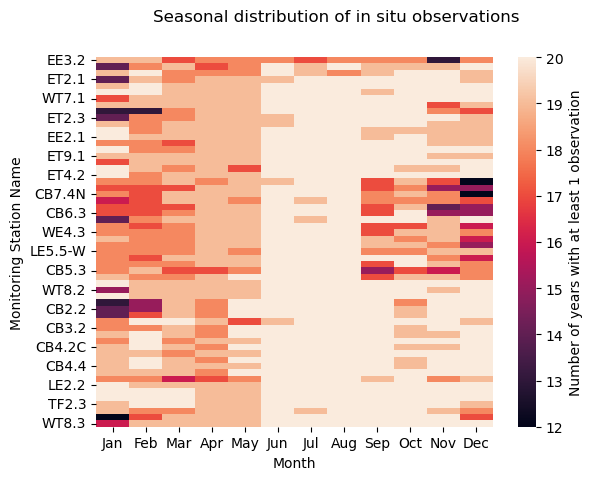

In [ ]:
fig, ax = plt.subplots()
fig.suptitle('Seasonal distribution of in situ observations')

sns.heatmap(completeness_df, ax=ax, cbar_kws={'label': 'Number of years with at least 1 observation'})
ax.set_ylabel('Monitoring Station Name')
ax.set_xlabel('Month')

In [19]:
wq_stations = wq_stations[wq_stations.Station.isin(stations_filtered)]

### Plot location of the stations

In [20]:
wq_counts = wq_stations.groupby('Station').mean(numeric_only=True)[['Latitude', 'Longitude']]
wq_counts['Count'] = wq_stations.groupby('Station').count()['EventId']

In [21]:
geoWQ = gpd.GeoDataFrame(
    wq_counts, geometry=gpd.points_from_xy(wq_counts['Longitude'], wq_counts['Latitude']), 
    crs='epsg:4326')

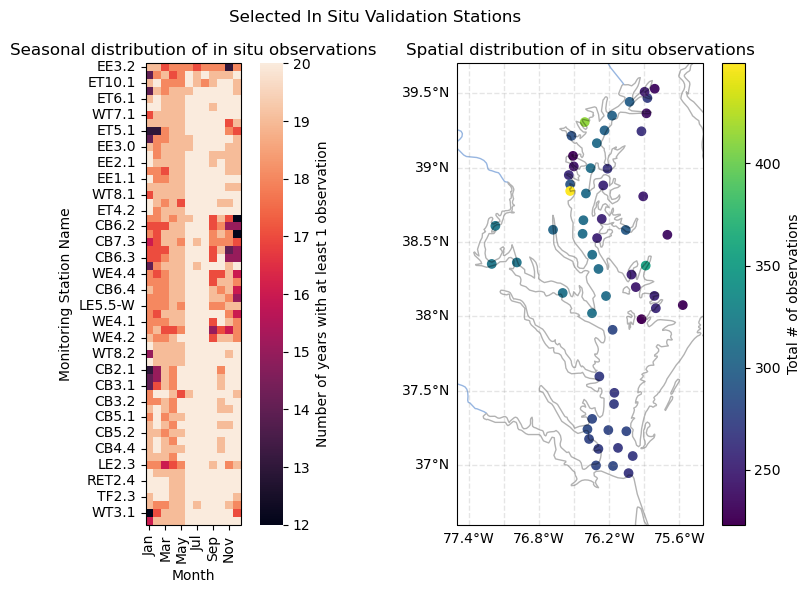

In [58]:
# ax1 = plt.subplot(121)
# ax2 = plt.subplot(122, projection=ccrs.PlateCarree())
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()})
                        # gridspec_kw={'width_ratios':[2, 1]})  # , 'height_ratios':[2,1]})
fig.suptitle('Selected In Situ Validation Stations')

fig.set_size_inches(9, 6)
# fig.suptitle('Locations of most frequently sampled in situ locations')

# Add background features
axes[1].add_feature(cfeature.COASTLINE, alpha=0.3)
axes[1].add_feature(cfeature.BORDERS, linestyle=':')
axes[1].add_feature(cfeature.RIVERS)
# ax.coastlines()

axes[1].set_extent([-77.5, -75.4, 36.6, 39.7])

# Add and format gridlines. Remove top and right labels
gl = axes[1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.2, linestyle='--')
gl.top_labels, gl.right_labels = False, False

# Add seasonal distribution
axes[0].set_title('Seasonal distribution of in situ observations')
sns.heatmap(completeness_df, ax=axes[0], 
            cbar_kws={'label': 'Number of years with at least 1 observation'})
axes[0].set_ylabel('Monitoring Station Name')
axes[0].set_xlabel('Month')
axes[0].set_xticks([0.5, 2.5, 4.5, 6.5, 8.5, 10.5])
axes[0].set_xticklabels(['Jan','Mar','May','Jul', 'Sep', 'Nov'])

# Add MUR to left plot
axes[1].set_title('Spatial distribution of in situ observations')
geoWQ.plot(ax=axes[1], column='Count', legend=True, legend_kwds={'label': "Total # of observations"})

plt.tight_layout()

if SAVE_FIGS: 
    plt.savefig('../../figures/insitu_distribution.png', dpi=400, 
            bbox_inches='tight')

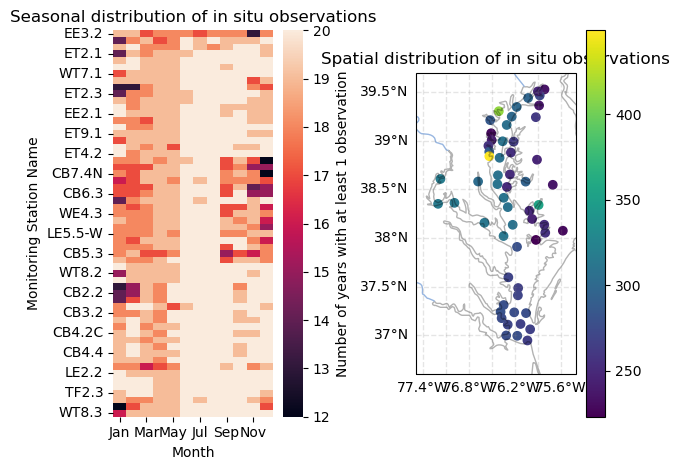

In [39]:
ax0 = plt.subplot(121)
ax1 = plt.subplot(122, projection=ccrs.PlateCarree())
# fig, axes = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle('Selected In Situ Validation Stations')

fig.set_size_inches(7, 16)
# fig.suptitle('Locations of most frequently sampled in situ locations')

# Add background features
ax1.add_feature(cfeature.COASTLINE, alpha=0.3)
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.add_feature(cfeature.RIVERS)
# ax.coastlines()

ax1.set_extent([-77.5, -75.4, 36.6, 39.7])

# Add and format gridlines. Remove top and right labels
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.2, linestyle='--')
gl.top_labels, gl.right_labels = False, False

# Add seasonal distribution
ax0.set_title('Seasonal distribution of in situ observations')
sns.heatmap(completeness_df, ax=ax0, 
            cbar_kws={'label': 'Number of years with at least 1 observation'})
ax0.set_ylabel('Monitoring Station Name')
ax0.set_xlabel('Month')

# Add MUR to left plot
ax1.set_title('Spatial distribution of in situ observations')
geoWQ.plot(ax=ax1, column='Count', legend=True)

plt.tight_layout()

In [29]:
axes

array([<GeoAxesSubplot: title={'center': 'Seasonal distribution of in situ observations'}, xlabel='Month', ylabel='Monitoring Station Name'>,
       <GeoAxesSubplot: title={'center': 'Spatial distribution of in situ observations'}>],
      dtype=object)

**Top most sampled stations from several areas of the bay**

- CB5.1 -- main stem outside the Patuxent River
- RET2.4 -- up the Potomac River
- CB7.2 -- main stem near the exit of the Bay

## Compute the Climatologial Value for each Depth and Location

In [17]:
counts = wq_stations.groupby(['Station', wq_stations.SampleDate.dt.year, wq_stations.SampleDate.dt.month]).count()['MeasureValue']
counts = pd.DataFrame(counts)
counts = counts.rename({'MeasureValue': 'ObsCount'}, axis=1)
counts.index = counts.index.set_names(['Station', 'year', 'month'])

In [18]:
counts['MeasureValue'] = wq_stations.groupby(['Station', wq_stations.SampleDate.dt.month])['MeasureValue'].mean()

In [19]:
counts

ObsCount  MeasureValue
Station year month                        
CB2.1   2003 1             1           NaN
             3             1           NaN
             4             2           NaN
             5             2           NaN
             6             1           NaN
...                      ...           ...
WT8.3   2022 8             1           NaN
             9             2           NaN
             10            2           NaN
             11            2           NaN
             12            2           NaN

[13232 rows x 2 columns]

In [20]:
wq_clim = wq_stations.groupby(['Station', wq_stations.SampleDate.dt.month])['MeasureValue'].mean(numeric_only=True)

In [21]:
wq_clim = wq_clim.dropna().sort_index().reset_index()  \
    .rename(columns={'SampleDate': 'Month', 'MeasureValue': 'ClimValue'})

In [22]:
wq_clim

,Station,Month,ClimValue
0,CB2.1,1,3.138462
1,CB2.1,2,2.513333
2,CB2.1,3,6.000000
3,CB2.1,4,12.712000
4,CB2.1,5,18.592593
...,...,...,...
691,WT8.3,8,27.102564
692,WT8.3,9,23.623077
693,WT8.3,10,17.070000
694,WT8.3,11,10.916667


## Compute Anomalies

In [23]:
wq_stations['Month'] = wq_stations.SampleDate.dt.month
# Averaging if there are multiple observations at the same depth
wq_stations = wq_stations.groupby(['Station', 'SampleDate']).mean(numeric_only=True).drop('Depth', axis=1)
wq_stations = wq_stations.reset_index()

In [24]:
wq = pd.merge(wq_stations, wq_clim, on=['Station', 'Month'])  \
    .drop(columns=['Month', 'EventId'])

In [25]:
len(wq.Station.unique())

58

In [26]:
wq['MeasureAnomaly'] = wq['MeasureValue'] - wq['ClimValue']

In [29]:
path = os.path.join(REPO_ROOT, 'data/interim', 'cbp_stations_climatology_anomaly_filtered.csv')
wq.to_csv(path, index=False)

## Exploring Feasibility of creating a climatology

In [ ]:
cb51 = wq_clim[wq_clim.Station == 'CB5.1'].reset_index()
cb72 = wq_clim[wq_clim.Station == 'CB7.2'].reset_index()

In [ ]:
cb51.SampleDate.hist(bins=20)

Seems to be one station per month. Exact dates do not repeat exactly. We can get monthly climatologies, then. To compare to the sst I could either
1. average a month together
2. pick out specifically the same days as the in situ

I'm leaning toward no. 2, because it feels like a more similar comparison

In [ ]:
cb51.groupby([cb51.SampleDate.dt.month, 'Depth']).count()

Honestly at least between these two the depths are more standard than I gave them credit for. I can probably avoid interpolation, but I will still drop depths with fewer than a certain number of points.

In [ ]:
depths_cb72 = cb72.Depth.unique()

In [ ]:
depths_cb72

In [ ]:
depths = cb51.Depth.unique()

In [ ]:
depths

This is the function that is going to have to get more complex. Need to check counts, for example.

## Plotting Climatologies

### Preprocessing

1 - adding relevant datetime columns

In [ ]:
wq['month'] = wq['SampleDate'].dt.month
wq['day'] = wq['SampleDate'].dt.day

2 - sorting into each station

In [ ]:
cb51 = wq[wq.Station == 'CB5.1'].reset_index()
ret24 = wq[wq.Station == 'RET2.4'].reset_index()
cb72 = wq[wq.Station == 'CB7.2'].reset_index()

### Compute means

In [ ]:
cb51_grouped = cb51.groupby(['month', 'Depth']) \
    .mean(numeric_only=True)['MeasureValue'].reset_index()

### Plot

In [ ]:
fig, ax = plt.subplots(1,1)
cb51_grouped[cb51_grouped.month == 1].plot.scatter(ax=ax, x='MeasureValue', y='Depth', color='yellow')
cb51_grouped[cb51_grouped.month == 2].plot.scatter(ax=ax, x='MeasureValue', y='Depth', color='orange')
cb51_grouped[cb51_grouped.month == 3].plot.scatter(ax=ax, x='MeasureValue', y='Depth', color='red')
cb51_grouped[cb51_grouped.month == 4].plot.scatter(ax=ax, x='MeasureValue', y='Depth', color='pink')
cb51_grouped[cb51_grouped.month == 5].plot.scatter(ax=ax, x='MeasureValue', y='Depth', color='lavender')
cb51_grouped[cb51_grouped.month == 6].plot.scatter(ax=ax, x='MeasureValue', y='Depth', color='purple')
cb51_grouped[cb51_grouped.month == 7].plot.scatter(ax=ax, x='MeasureValue', y='Depth', color='darkcyan')
cb51_grouped[cb51_grouped.month == 8].plot.scatter(ax=ax, x='MeasureValue', y='Depth', color='blue')
cb51_grouped[cb51_grouped.month == 9].plot.scatter(ax=ax, x='MeasureValue', y='Depth', color='green')
cb51_grouped[cb51_grouped.month == 10].plot.scatter(ax=ax, x='MeasureValue', y='Depth', color='darkgreen')
cb51_grouped[cb51_grouped.month == 11].plot.scatter(ax=ax, x='MeasureValue', y='Depth', color='grey')
cb51_grouped[cb51_grouped.month == 12].plot.scatter(ax=ax, x='MeasureValue', y='Depth', color='black')

In [ ]:
cb51_grouped.pivot(index='MeasureValue', columns='month', values='Depth')

### Plot

In [ ]:
df = cb51_grouped.reset_index().pivot(index='month', 
                                      columns='Depth', values='MeasureValue')

In [ ]:
df.plot()

In [ ]:
df = pd.DataFrame([['red', 0, 0], ['red', 1, 1], ['red', 2, 2], ['red', 3, 3], ['red', 4, 4], ['red', 5, 5], ['red', 6, 6], ['red', 7, 7], ['red', 8, 8], ['red', 9, 9], ['blue', 0, 0], ['blue', 1, 1], ['blue', 2, 4], ['blue', 3, 9], ['blue', 4, 16], ['blue', 5, 25], ['blue', 6, 36], ['blue', 7, 49], ['blue', 8, 64], ['blue', 9, 81]],
                  columns=['color', 'x', 'y'])
df

In [ ]:
# pivot the data into the correct shape
df = df.pivot(index='x', columns='color', values='y')
df

In [ ]:
# plot the pivoted dataframe; if the column names aren't colors, remove color=df.columns
df.plot(color=df.columns, figsize=(5, 3))

In [ ]:
ts = pd.Series(np.random.randn(1000), index=pd.date_range("1/1/2000", periods=1000))
df = pd.DataFrame(np.random.randn(1000, 4), index=ts.index, columns=list("ABCD"))

df = df.cumsum()
df

## Monthly Climatology Plot for One Station

### Calculate

In [ ]:
cb51 = wq_stations[wq_stations.Station == 'CB5.1'].reset_index()

In [ ]:
def filter_mean(df):
    # 19 years of data right now
    if len(df) < 18:
        # print('fewer than 15 points. Dropping month', df.SampleDate.dt.month.iloc[0],
        #       'at depth', df.Depth.iloc[0])
        val = np.nan
    else:
        val = np.mean(df.MeasureValue)
    return val

In [ ]:
# Group the point by month and depth and average points
cb51_clim = cb51.drop(['index', 'EventId'], axis=1) \
    .groupby([cb51.SampleDate.dt.month, 'Depth']).apply(filter_mean)
# Reformat
cb51_clim = cb51_clim.dropna().sort_index().reset_index(name='MeasureValue')

### Plot the Climatology for one station

In [ ]:
# Make months easier to read
# TODO is this guaranteed to keep its order?
months_mapping = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 
    9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
cb51_clim = cb51_clim.replace({'SampleDate': months_mapping})

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
fig.suptitle('Monthly Climtological Temperatures for Station CB5.1 (main stem outside Patuxent)')

# Format the colorbar
cmap = plt.cm.twilight
norm = matplotlib.colors.BoundaryNorm(range(1, 15), cmap.N)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
# Assign a color to each month
color_dict = {}
months = months_mapping.values()
for i, month in enumerate(months):
    color_dict[month] = sm.to_rgba(i+1)

# Plot the data
cb51_clim.plot.scatter(ax=ax,x='MeasureValue', y='Depth', 
                       color = [color_dict[i] for i in cb51_clim['SampleDate']])

# Format the axes and lables
ax.invert_yaxis()
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.set_xlabel('Observed Temperature ($^o$C)', loc='center')
ax.set_ylabel('Depth (m)')
ax.xaxis.set_label_position('top')

fig.colorbar(sm, orientation='horizontal', label="Month")

plt.tight_layout()

## Side quest about ocean preconditioning

In [ ]:
cb63 = wq[wq.Station == 'CB6.3']
# cb62 = wq[wq.Station == 'CB6.2']

In [ ]:
cb63 = cb63[(cb63.SampleDate > '2016-07-10') & (cb63.SampleDate < '2016-09-30')]
# cb62 = cb62[(cb62.SampleDate > '2016-07-10') & (cb62.SampleDate < '2016-09-30')]

Samples taken: July 11th, July 25th, August 8th, August 29th, Sept 26

In [ ]:
cb63

In [ ]:
print(cb63.SampleDate.unique())
# print(cb62.SampleDate.unique())

In [ ]:
cb63[cb63.SampleDate == d]

In [ ]:
fig, axes = plt.subplots(2, 3)
fig.set_size_inches(10, 6)

for ax in axes.flatten():
    ax.invert_yaxis()
    ax.set_xlim([24, 30])
    
dates = ['2016-07-11', '2016-07-25', '2016-08-08', '2016-08-29',
        '2016-09-26']

d = dates[0]
cb63[cb63.SampleDate == d].plot.scatter(
    ax=axes[0, 0], y='Depth', x='MeasureValue', title=d
)

d = dates[1]
cb63[cb63.SampleDate == d].plot.scatter(
    ax=axes[0, 1], y='Depth', x='MeasureValue', title=d
)

d = dates[2]
cb63[cb63.SampleDate == d].plot.scatter(
    ax=axes[0, 2], y='Depth', x='MeasureValue', title=d
)

d = dates[3]
cb63[cb63.SampleDate == d].plot.scatter(
    ax=axes[1, 0], y='Depth', x='MeasureValue', title=d
)

d = dates[4]
cb63[cb63.SampleDate == d].plot.scatter(
    ax=axes[1, 1], y='Depth', x='MeasureValue', title=d
)

plt.tight_layout()